In [1]:
from datetime import date

import pandas_datareader.data as web
import pandas as pd
import matplotlib.ticker as mtick

In [2]:
report_start = date.fromisoformat('2020-01-01')
report_end = date.today()

In [3]:
data = (
    web.get_data_fred(
        ["DGS5", "DGS10", "T5YIE", "T10YIE", "T10Y2Y", "T10Y3M"],
        report_start,
        report_end,
    )
    / 100.0
)
data.dropna(inplace=True)

columns_with_semiannual_comp = [0, 1, 3, 4]

# Converting all CMT Yields to APY (i.e. all but breakdown inflation rates)
data.iloc[:, columns_with_semiannual_comp] = (data.iloc[:, columns_with_semiannual_comp]/2 + 1) ** 2 - 1

In [4]:
data["10y Tr. Yield - 5y Tr. Yield"] = data.DGS10 - data.DGS5
data["10y Breakeven Infl. Rate - 5y Breakeven Infl. Rate"] = data.T10YIE - data.T5YIE

data.rename(
    columns={
        "T10Y2Y": "10y Tr. Yield - 2y Tr. Yield",
        "T10Y3M": "10y Tr. Yield - 3m Tr. Yield",
    },
    inplace=True,
)

In [5]:
# Get rid columns no longer required
data.drop(columns=data.columns[0:4], inplace=True)

# Rearrange columns
data = data.iloc[:, [2, 3, 0 ,1]]

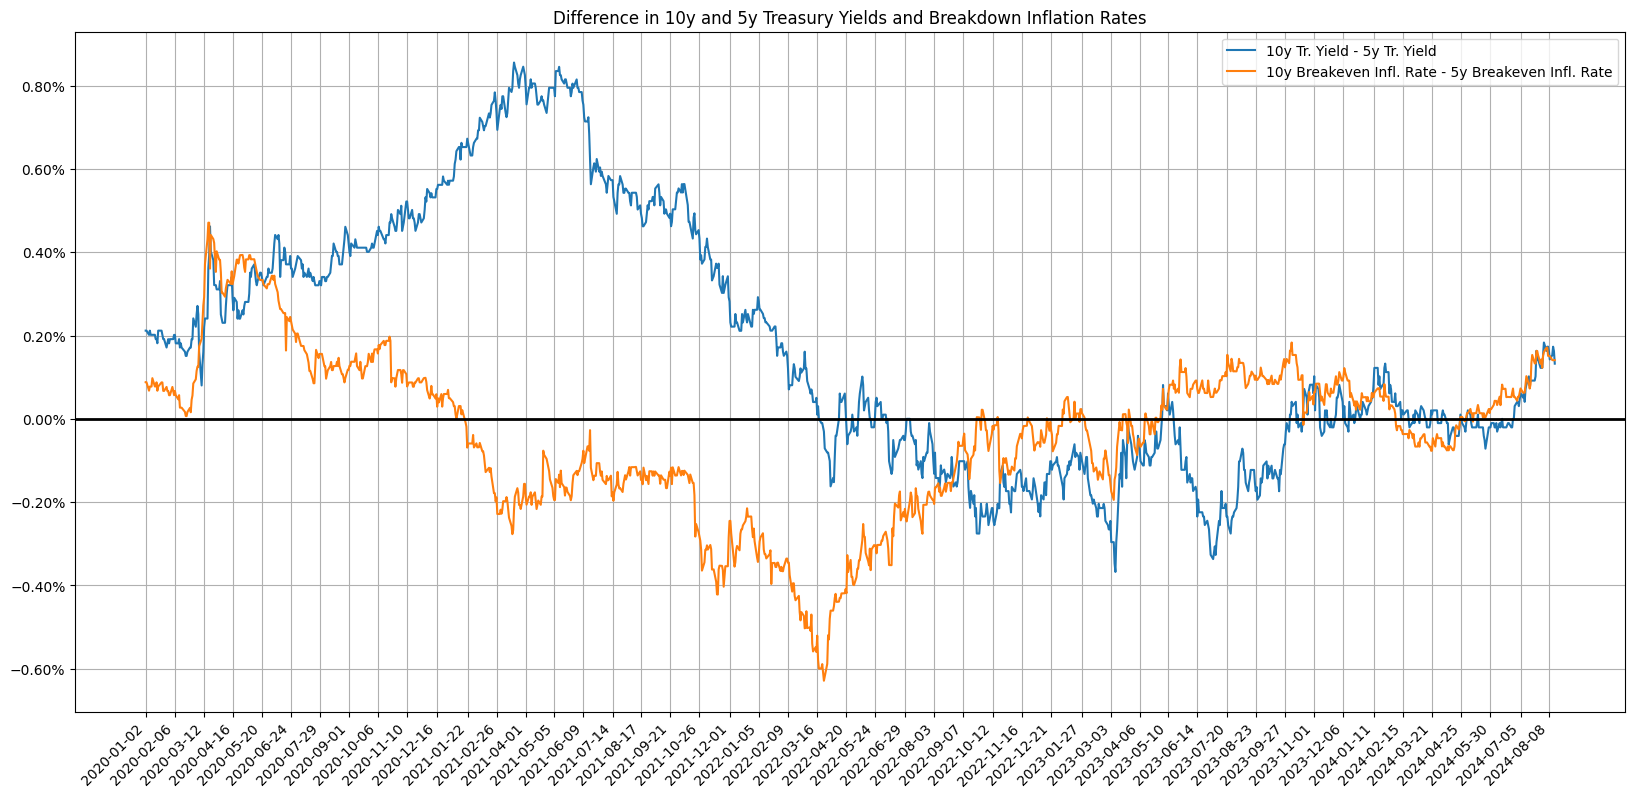

In [6]:
ax = data.iloc[:, :2].plot(
    figsize=(20, 10),
    grid=True,
    title="Difference in 10y and 5y Treasury Yields and Breakdown Inflation Rates",
    xticks=data.index[::24],
    xlabel="",
    rot=45,
)

ax.axhline(y=0, lw=2, c='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

In [7]:
date_of_inversion = data.iloc[:, 0][data.iloc[:, 0] < 0].index[0]
date_of_inversion_peak = data.iloc[:, 0].idxmin()
print(
    f"The inversion of 10-Year - 5-Year yield curves happened on {date_of_inversion:%Y-%m-%d}"
)

print(
    f"The peak of inversion was {data.iloc[:,0].min()*1e4:.0f}bps and took place on {date_of_inversion_peak:%Y-%m-%d}"
)

print(
    f"The inversion amounts to {data.iloc[-1,0]*1e4:+.0f}bps as of {data.index[-1]:%Y-%m-%d}"
)

The inversion of 10-Year - 5-Year yield curves happened on 2022-03-21
The peak of inversion was -37bps and took place on 2023-03-08
The inversion amounts to +13bps as of 2024-08-15


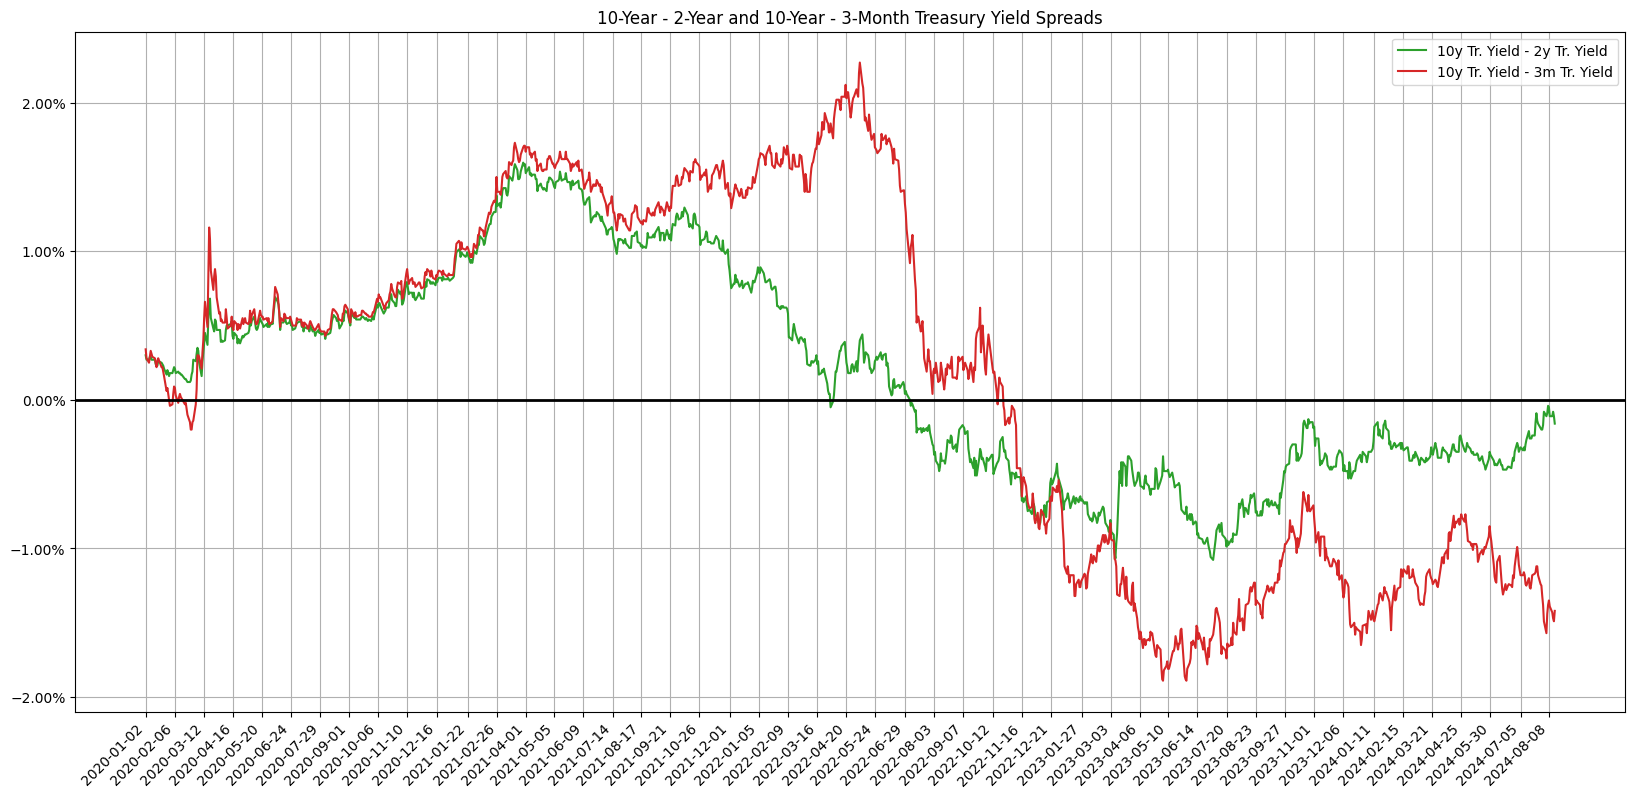

In [8]:
ax = data.iloc[:, 2:].plot(
    figsize=(20, 10),
    grid=True,
    title="10-Year - 2-Year and 10-Year - 3-Month Treasury Yield Spreads",
    color=["#2ca02c", "#d62728"],
    xticks=data.index[::24],
    xlabel="",
    rot=45,
)

ax.axhline(y=0, lw=2, c="k")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

In [9]:
date_of_inversion = data.iloc[:, 2][data.iloc[:, 2] < 0].index[0]
date_of_inversion_peak = data.iloc[:, 2].idxmin()
print(
    f"The inversion of 10-years - 2-Year yields curves happened on {date_of_inversion_peak:%Y-%m-%d}"
)
print(
    f"The peak of inversion was {data.iloc[:,2].min()*1e4:.0f}bps and took place on {date_of_inversion_peak:%Y-%m-%d}"
)
print(
    f"The inversion amounts to {data.iloc[-1,2]*1e4:+.0f}bps as of {data.index[-1]:%Y-%m-%d}"
)

The inversion of 10-years - 2-Year yields curves happened on 2023-07-03
The peak of inversion was -108bps and took place on 2023-07-03
The inversion amounts to -16bps as of 2024-08-15


In [10]:
data2 = (
    web.get_data_fred(
        ["EXPINF5YR", "T5YIEM", "EXPINF2YR", "T10YIEM", "EXPINF10YR", "T10Y2YM"],
        "2000-01-01",
        report_end,
    )
    / 100
)

data2.dropna(inplace=True)

In [11]:
# Only T10Y2YM is based on a yield with a semiannual compounding frequency
columns_with_semiannual_comp = ["T10Y2YM"]

# Converting all CMT Yields to APY (i.e. all but breakdown inflation rates)
data2.loc[:, columns_with_semiannual_comp] = (
    data2.loc[:, columns_with_semiannual_comp] / 2 + 1
) ** 2 - 1

In [12]:
abs_diff = (data2.iloc[:, 0] - data2.iloc[:, 1].abs())
abs_diff.describe()

count    259.000000
mean      -0.000581
std        0.004321
min       -0.014320
25%       -0.002367
50%       -0.000119
75%        0.001457
max        0.019487
dtype: float64

In [13]:
abs_diff.sem()

np.float64(0.0002685215590127872)

In [14]:
# Getting rid of no longer needed columns, and calculating the difference between 10-Year and 2-Year
# expected inflation
data2["10y Breakeven Infl. Rate - 2y Expected Infl. Rate"] = (
    data2.iloc[:, 3] - data2.iloc[:, 2]
)
data2["10y Expected Infl. Rate - 2y Expected Infl. Rate"] = (
    data2.iloc[:, 4] - data2.iloc[:, 2]
)
data2 = data2.iloc[:, 5:]
data2.rename(columns={"T10Y2YM": "10y Tr. Yield - 2y Tr. Yield"}, inplace=True)

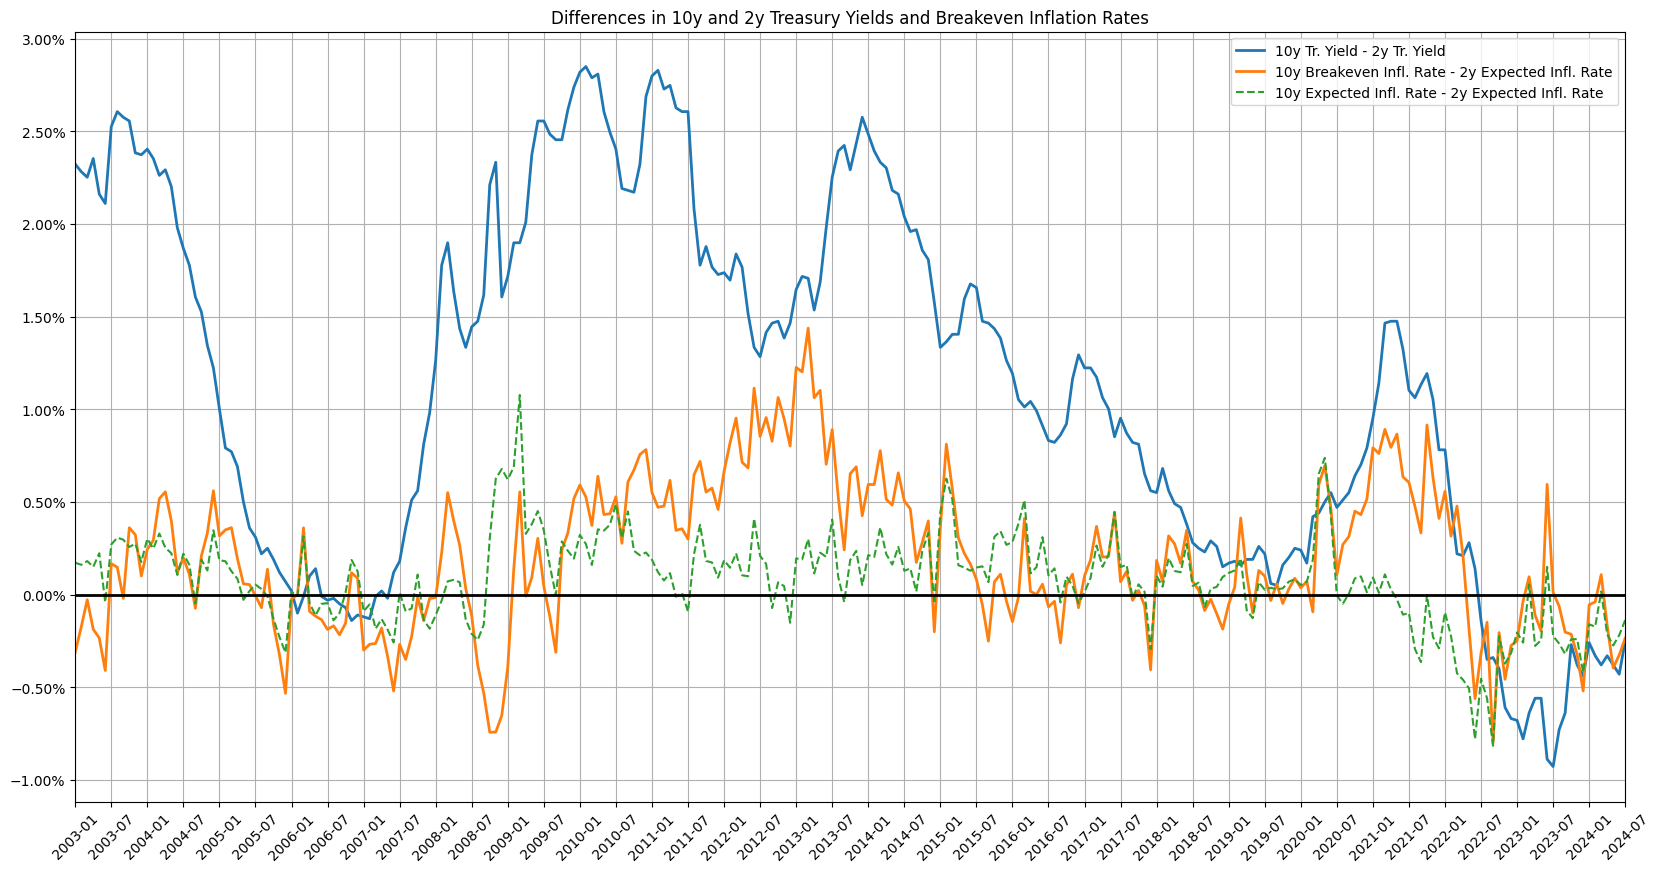

In [15]:
ax = data2.iloc[:, :2].plot(
    figsize=(20, 10),
    grid=True,
    linewidth=2,
    title="Differences in 10y and 2y Treasury Yields and Breakeven Inflation Rates",
    xticks=data2.index[::6],
    xlabel="",
    rot=45,
)
ax = data2.iloc[:, 2:].plot(
    ax=ax, grid=True, xticks=data2.index[::6], xlabel="", rot=45, linestyle="--"
)
ax.axhline(y=0, lw=2, c="k")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map("{:%Y-%m}".format, data2.index[::6])))